# Predicting Stock Market Performance with Twitter and Reddit
By: Asher Gilani, Hasan Muhammad, Arjun Rajkumar

## Objectives
The rise of social media has given access to a huge volume of discussion on almost any topic imaginable. One such topic is company-related news with social media discussion acting as a proxy for public sentiment towards a given brand. We want to use discussion on social media to to try and predict performance of big companies in the stock market. We will try to use the sentiments shared towards companies on Twitter as an initial benchmark to compare against stock market movement. Then, we will look at investing communities on Reddit to see how discussions on another platform compare. If a correlation is found, we will have found a valuable source for companies to get instantaneous snapshots of how they are viewed by the public and how that image effects their monetary value. 

## Roadmap
- First explore/clean up the Kaggle Twitter Dataset
- Query the Yahoo Finance API for stocks to match the Twitter Dataset
- Use NLP and Vader sentiment analysis to generate a sentiment score for each tweet
- Use Twitter API to collect more recent stocks and do the same NLP processing
- Examine sentiment-stock correlations
- Build Linear Regression models to predict stock prices with sentiment scores
- Use Reddit API to examine stock sentiment

## Data Sources
- Twitter Kaggle Dataset
- Yahoo Finance API
- Twitter API (Tweepy)
- Reddit API (PRAW)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from datetime import datetime, timedelta

import yfinance as yf
import tweepy
import config

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
nltk.download('stopwords')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn import linear_model as lm
import statsmodels
import statsmodels.api

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asher\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asher\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Exploration of [Twitter Kaggle Dataset](https://www.kaggle.com/davidwallach/financial-tweets)
This dataset contains financial tweets regarding stocks traded on NYSE, NASDAQ, and the S&P 500.

In [2]:
skiprows = [730, 2835, 3057, 3112, 3193, 3204, 3254, 3519, 4077, 4086, 4087, 4498]
tweet_df = pd.read_csv('./datasets/stockerbot-export.csv', skiprows=skiprows, parse_dates=['timestamp'])

# Drop last five rows since they seem to be in a different language
tweet_df = tweet_df[:-5]
tweet_df.head()

,id,text,timestamp,source,symbols,company_names,url,verified
0,1019696670777503700,VIDEO: “I was in my office. I was minding my o...,2018-07-18 21:33:26+00:00,GoldmanSachs,GS,The Goldman Sachs,https://twitter.com/i/web/status/1019696670777...,True
1,1019709091038548000,The price of lumber $LB_F is down 22% since hi...,2018-07-18 22:22:47+00:00,StockTwits,M,Macy's,https://twitter.com/i/web/status/1019709091038...,True
2,1019711413798035500,Who says the American Dream is dead? https://t...,2018-07-18 22:32:01+00:00,TheStreet,AIG,American,https://buff.ly/2L3kmc4,True
3,1019716662587740200,Barry Silbert is extremely optimistic on bitco...,2018-07-18 22:52:52+00:00,MarketWatch,BTC,Bitcoin,https://twitter.com/i/web/status/1019716662587...,True
4,1019718460287389700,How satellites avoid attacks and space junk wh...,2018-07-18 23:00:01+00:00,Forbes,ORCL,Oracle,http://on.forbes.com/6013DqDDU,True


Text(0.5, 0, 'Number of Times Tweeted')

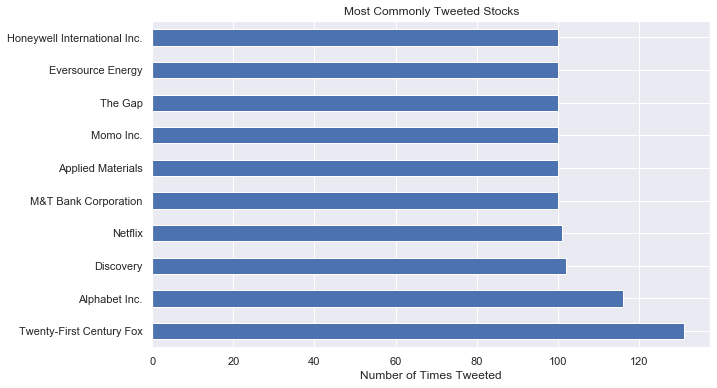

In [3]:
ax = tweet_df.company_names.value_counts().sort_values(ascending=False).head(10).plot.barh(figsize=(10, 6))
ax.set_title('Most Commonly Tweeted Stocks')
ax.set_xlabel('Number of Times Tweeted')

It is nice to see that this dataset has many tweets (around 100) for the most frequent companies. This will help us in determing the general sentiment around these companies over time to compare to stock prices. Many big names such as 21st Century Fox, Alphabet (parent company of Google), and Netflix also appear which are very established companies.

Text(0.5, 0, 'Twitter Users')

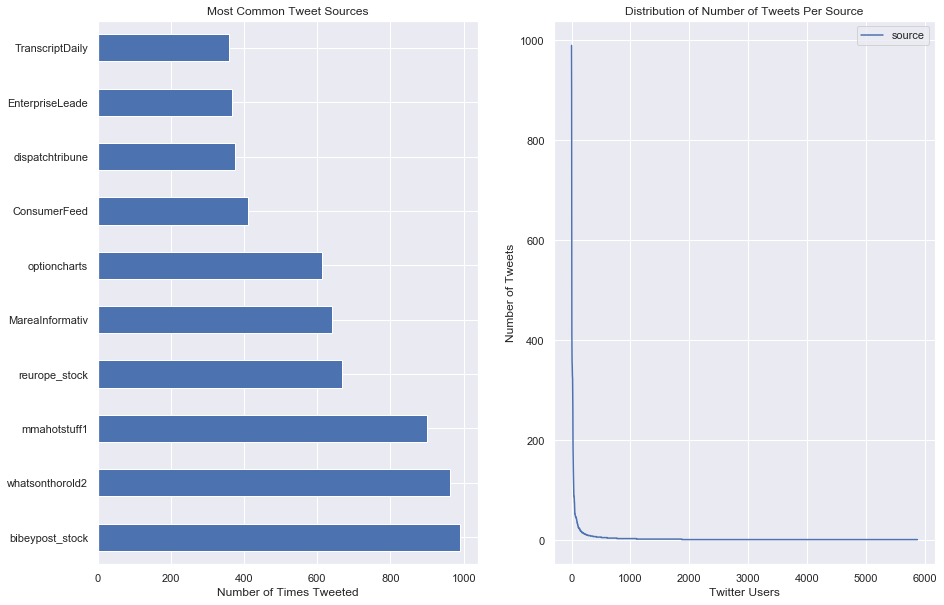

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2)

tweet_df.source.value_counts().head(10).plot.barh(ax=ax1, figsize=(15, 10))
ax1.set_title('Most Common Tweet Sources')
ax1.set_xlabel('Number of Times Tweeted')

tweet_df.source.value_counts().reset_index().plot(ax=ax2)
ax2.set_title('Distribution of Number of Tweets Per Source')
ax2.set_ylabel('Number of Tweets')
ax2.set_xlabel('Twitter Users')

This is also a nice feature of our data. The bar chart on the left worried me that our dataset was only going to have a few users that tweet a lot. This would create a lot of bias in any correlations we find. But if you look at the distribution graph on the right, it shows that there are only a few users who really tweet a lot; most users in this dataset only tweet a few times which gives us a better sample. Later we will try using the Twitter API to get an even broader collection of tweet sources.

Text(0, 0.5, 'Count')

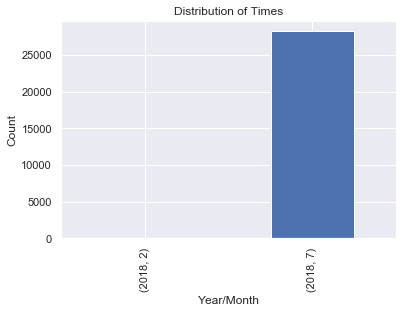

In [5]:
ax = tweet_df.groupby([tweet_df.timestamp.dt.year, tweet_df.timestamp.dt.month])['id'].count().plot(kind='bar')
ax.set_title('Distribution of Times')
ax.set_xlabel('Year/Month')
ax.set_ylabel('Count')

The one unfortunate thing about this dataset is it primarily includes tweets from July 2018 and a few tweets it seems from February 2018. We will likely need to pull in more data using the Twitter API, but this dataset will provide a good starting place.

# Collecting Stock Data Through the Yahoo Finance API
We were originally going to compare this Twitter dataset against some Kaggle stocks datasets. Given that our Twitter dataset only covers one month and the Kaggle datasets are very large, we are instead going to use the yfinance Python module to collect data for this specific month.

In [6]:
# Lets identify the top 30 stocks (based on frequency) from our Twitter dataset and use that with yfinance
common_tickers = tweet_df.symbols.value_counts().sort_values(ascending=False).head(30)
common_tickers.head()

NFLX    101
MOMO    100
ES      100
GPS     100
AMAT    100
Name: symbols, dtype: int64

In [7]:
# Queries Yahoo Finance API for these stocks on the month of July 2018
stocks_df = yf.download(tickers=list(common_tickers.index), start='2018-07-01', end='2018-07-31')
stocks_df.head()

[*********************100%***********************]  30 of 30 completed

3 Failed downloads:
- FOX: Data doesn't exist for startDate = 1530417600, endDate = 1533009600
- ARNC: Data doesn't exist for startDate = 1530417600, endDate = 1533009600
- OMG: No data found for this date range, symbol may be delisted


Adj Close                                         \
                          ABBV       AMAT ARNC         BLK          D   
Date                                                                    
2018-07-02 00:00:00  80.599098  43.812244  NaN  465.989349  61.225769   
2018-07-03 00:00:00  81.031921  42.968220  NaN  458.311768  61.995003   
2018-07-05 00:00:00  81.785034  43.582054  NaN  458.955444  62.379616   
2018-07-06 00:00:00  83.897171  44.243843  NaN  458.684906  62.630074   
2018-07-09 00:00:00  84.001045  44.617893  NaN  470.261902  60.894825   

                                                                      ...  \
                           DFS         ES         ESS FOX        GPS  ...   
Date                                                                  ...   
2018-07-02 00:00:00  66.760170  55.400024  220.294998 NaN  28.312382  ...   
2018-07-03 00:00:00  66.187805  55.869362  220.294998 NaN  28.767450  ...   
2018-07-05 00:00:00  66.225349  56.057095  222.607773 NaN  28.196383  ...   
2018-07-06 00:00:00  66.093971  56.610909  223.838806 NaN  27.893003  ...   
2018-07-09 00:00:00  67.576477  54.874374  222.589127 NaN  27.500397  ...   

                      Volume                                           \
                        MOMO      MTB      NFLX     NTNX OMG       ON   
Date                                                                    
2018-07-02 00:00:00  4815300   732600   8142500  2096200 NaN  4726700   
2018-07-03 00:00:00  2118100   383100   5280300  1296300 NaN  2400500   
2018-07-05 00:00:00  3498100   680100   8448900  2332100 NaN  7132400   
2018-07-06 00:00:00  4059300   829500   8629600  2291100 NaN  4202200   
2018-07-09 00:00:00  5586900  1108800  11127500  2527400 NaN  3749400   

                                                         
                          PBR    SQQQ      TEL      UPS  
Date                                                     
2018-07-02 00:00:00  14640200  749600  1671100  2252300  
2018-07-03 00:00:00  15707700  509200   815400  1145700  
2018-07-05 00:00:00  21271900  841100  1521900  2866800  
2018-07-06 00:00:00  13076300  837000   986000  2022400  
2018-07-09 00:00:00  18007000  617600  1140300  2103600  

[5 rows x 180 columns]

# Cleaning Yahoo Finance Data

In [8]:
# Only want Open, Close, and Volume. Drop the rest
stocks_df.drop(['Adj Close', 'Low', 'High'], axis=1, inplace=True)

# Columns are multi-indexed, so flatten this
stocks_df.columns = ['_'.join(multi_col) for multi_col in stocks_df.columns]

# Drop FOX, OMG, and ARNC cols since we weren't able to get data for them
stocks_df.drop(list(stocks_df.filter(regex='(FOX)|(OMG)|(ARNC)$')), axis=1, inplace=True)

stocks_df.head()

,Close_ABBV,Close_AMAT,Close_BLK,Close_D,Close_DFS,Close_ES,Close_ESS,Close_GPS,Close_GRPN,Close_HLT,...,Volume_MHK,Volume_MOMO,Volume_MTB,Volume_NFLX,Volume_NTNX,Volume_ON,Volume_PBR,Volume_SQQQ,Volume_TEL,Volume_UPS
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-02 00:00:00,93.110001,45.680000,499.519989,68.449997,71.150002,59.020000,236.220001,31.730000,86.199997,79.300003,...,839600,4815300,732600,8142500,2096200,4726700,14640200,749600,1671100,2252300
2018-07-03 00:00:00,93.610001,44.799999,491.290009,69.309998,70.540001,59.520000,236.220001,32.240002,85.199997,79.449997,...,405700,2118100,383100,5280300,1296300,2400500,15707700,509200,815400,1145700
2018-07-05 00:00:00,94.480003,45.439999,491.980011,69.739998,70.580002,59.720001,238.699997,31.600000,87.599998,79.690002,...,414600,3498100,680100,8448900,2332100,7132400,21271900,841100,1521900,2866800
2018-07-06 00:00:00,96.919998,46.130001,491.690002,70.019997,70.440002,60.310001,240.020004,31.260000,87.199997,80.559998,...,479100,4059300,829500,8629600,2291100,4202200,13076300,837000,986000,2022400
2018-07-09 00:00:00,97.040001,46.520000,504.100006,68.080002,72.019997,58.459999,238.679993,30.820000,96.599998,80.940002,...,426000,5586900,1108800,11127500,2527400,3749400,18007000,617600,1140300,2103600


This is a lot easier to work with. The data is not exactly tidy since the tickers are included in column names, but this has every price lined up by the date which should make it easier to graph. When graphing, we will just use regex to select the columns corresponding to a specific ticker. Such a dataset would be tidy. Later during the Twitter API parsing, we transform this dataset into tidy data.

# NLP and Sentiment Analysis on Tweets
Now that we have some tweets and stock price information for the corresponding time period, we can begin to do some analysis. We will start by doing some NLP on the Tweets and then we can compare them to changes in stock price over time.

We will be using VADER (Valence Aware Dictionary and Sentiment Reasoner) to figure out the sentiment. This gives us a reliable way of determining sentiment without labeling our own data and generating models. This rule-based analysis tool was explicitly designed for social media data which is perfect for our scenario.

In [9]:
# First filter for Tweets talking about our common tickers
relevant_tickers = tweet_df[tweet_df.symbols.isin(common_tickers.index)].reset_index()

print(relevant_tickers.shape)
relevant_tickers.head()

(2906, 9)


,index,id,text,timestamp,source,symbols,company_names,url,verified
0,8,1019720723441635300,Senate wants emergency alerts to go out throug...,2018-07-18 23:09:00+00:00,TechCrunch,NFLX,Netflix,https://tcrn.ch/2L8DsgT,True
1,21,1019737727477174300,Templeton and BlackRock say now's the time to ...,2018-07-19 00:16:34+00:00,business,BLK,BlackRock,https://bloom.bg/2NmXZLe,True
2,46,1016109247048945700,In 2 days I doubled my account with the option...,2018-07-08 23:58:17+00:00,HarryPickens2,HSY,The Hershey Company,http://Optionsbypros.com,False
3,82,1016153595522281500,Weekly Recap: $HSY price moved 4.28% since pos...,2018-07-09 02:54:31+00:00,aboutheoptions,HSY,The Hershey Company,https://twitter.com/i/web/status/1016153595522...,False
4,108,1016208393378283500,$AR $CGC $DAVE $GNC $HSY $ICON $KMB $M $PEP $P...,2018-07-09 06:32:15+00:00,SeekingAlpha,HSY,The Hershey Company,https://seekingalpha.com/article/4185993-shari...,False


## Cleaning Up Tweets with NLTK

In [10]:
tt = TweetTokenizer()

def clean_tweet(s):
    # Removing punctuation and stop words (e.g 'the', 'is', 'which')
    return ' '.join(wd for wd in tt.tokenize(s.lower()) if wd.isalnum() and wd not in set(stopwords.words('english')))

# Sample usage
print(relevant_tickers.text[1])
print(clean_tweet(relevant_tickers.text[1]))

Templeton and BlackRock say now's the time to buy emerging markets https://t.co/h4z90nxqwH https://t.co/6FkVrZlu3j
templeton blackrock say time buy emerging markets


In [11]:
# Now apply this cleanup to every tweet
relevant_tickers.text = relevant_tickers.text.apply(clean_tweet)
relevant_tickers.head()

,index,id,text,timestamp,source,symbols,company_names,url,verified
0,8,1019720723441635300,senate wants emergency alerts go netflix spoti...,2018-07-18 23:09:00+00:00,TechCrunch,NFLX,Netflix,https://tcrn.ch/2L8DsgT,True
1,21,1019737727477174300,templeton blackrock say time buy emerging markets,2018-07-19 00:16:34+00:00,business,BLK,BlackRock,https://bloom.bg/2NmXZLe,True
2,46,1016109247048945700,2 days doubled account option trades xrx mrtx,2018-07-08 23:58:17+00:00,HarryPickens2,HSY,The Hershey Company,http://Optionsbypros.com,False
3,82,1016153595522281500,weekly recap hsy price moved since post next s...,2018-07-09 02:54:31+00:00,aboutheoptions,HSY,The Hershey Company,https://twitter.com/i/web/status/1016153595522...,False
4,108,1016208393378283500,ar cgc dave gnc hsy icon kmb pep pg rrc smrt wtw,2018-07-09 06:32:15+00:00,SeekingAlpha,HSY,The Hershey Company,https://seekingalpha.com/article/4185993-shari...,False


## Perform Sentiment Analysis with Vader

In [12]:
sent = SentimentIntensityAnalyzer()
relevant_tickers['sentiment'] = relevant_tickers.text.apply(lambda s: sent.polarity_scores(s)['compound'])

# a compound sentiment value is positive if >= 0.05, negative if <= -0.05, neutral if in between
relevant_tickers.head()

,index,id,text,timestamp,source,symbols,company_names,url,verified,sentiment
0,8,1019720723441635300,senate wants emergency alerts go netflix spoti...,2018-07-18 23:09:00+00:00,TechCrunch,NFLX,Netflix,https://tcrn.ch/2L8DsgT,True,-0.3818
1,21,1019737727477174300,templeton blackrock say time buy emerging markets,2018-07-19 00:16:34+00:00,business,BLK,BlackRock,https://bloom.bg/2NmXZLe,True,0.0000
2,46,1016109247048945700,2 days doubled account option trades xrx mrtx,2018-07-08 23:58:17+00:00,HarryPickens2,HSY,The Hershey Company,http://Optionsbypros.com,False,0.0000
3,82,1016153595522281500,weekly recap hsy price moved since post next s...,2018-07-09 02:54:31+00:00,aboutheoptions,HSY,The Hershey Company,https://twitter.com/i/web/status/1016153595522...,False,-0.2960
4,108,1016208393378283500,ar cgc dave gnc hsy icon kmb pep pg rrc smrt wtw,2018-07-09 06:32:15+00:00,SeekingAlpha,HSY,The Hershey Company,https://seekingalpha.com/article/4185993-shari...,False,0.0000


So now each tweet has a value ranging from -1 to 1 representing how positive/negative the sentiment of the tweet is. My current worry is that many of these tweets are factual in nature meaning the sentiment score will not be indicative of stock performance. Later we will try to look at other things such as random Tweets from the last week and compare sentiment of those tweets to stock performance. For now let's take a look at the sentiment distribution.

Text(0, 0.5, 'Sentiment')

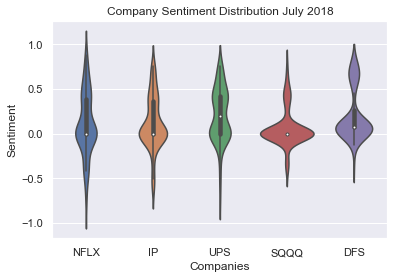

In [13]:
# Violin plot to show sentiment distribution
ticker_subset = relevant_tickers[relevant_tickers.symbols.isin(['NFLX', 'IP', 'SQQQ', 'DFS', 'UPS'])]
ax = sns.violinplot(x='symbols', y='sentiment', data=ticker_subset)
ax.set_title('Company Sentiment Distribution July 2018')
ax.set_xlabel('Companies')
ax.set_ylabel('Sentiment')

Looking at the sentiment distributions, we see that these companies generally have a neutral sentiment score which will not be very interesting for finding correlations to stock prices. SQQQ in particular has a lot of neutral tweets which makes sense since it is an index fund and it is harder to have an opinion on a collection of stocks. Even with all the neutral tweets, this data still shows unique insights as to how people feel about these companies since each company has a slightly different distribution. It's also interesting that while the companies do have clusters of positive tweets, there are relatively few negative ones in the dataset

## Sentiment vs Stock Price Performance
Now lets see how these sentiments over time correlate against stock performance

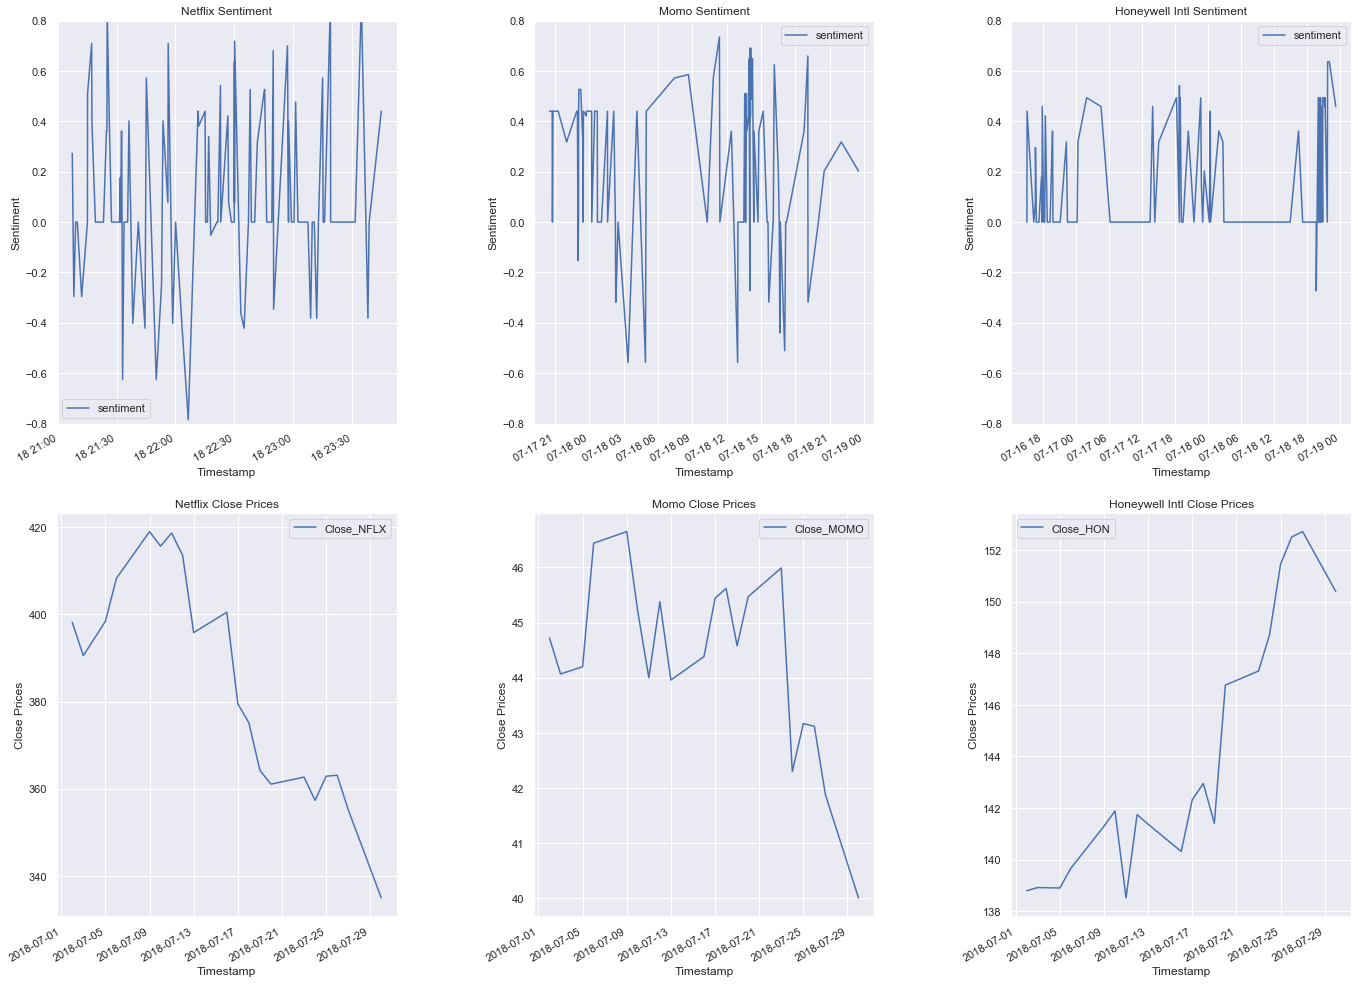

In [14]:
fig, axs = plt.subplots(2, 3)
syms = relevant_tickers.symbols
fig.tight_layout(pad=0.25)

# Graph Sentiment vs Time for 3 companies
axs[0, 0].set_ylim([-0.8, 0.8]); axs[0, 1].set_ylim([-0.8, 0.8]); axs[0, 2].set_ylim([-0.8, 0.8])
sentiment_kwargs = {'x': 'timestamp', 'y': 'sentiment', 'figsize': (20, 16), 'ylabel': 'Sentiment', 'xlabel': 'Timestamp'}

relevant_tickers[syms == 'NFLX'].plot.line(ax=axs[0, 0], title='Netflix Sentiment', **sentiment_kwargs)
relevant_tickers[syms == 'MOMO'].plot.line(ax=axs[0, 1], title='Momo Sentiment', **sentiment_kwargs)
relevant_tickers[syms == 'HON'].plot.line(ax=axs[0, 2], title='Honeywell Intl Sentiment', **sentiment_kwargs)

# Graph stock performance vs Time for 3 companies
price_kwargs = {'xlabel': 'Timestamp', 'ylabel': 'Close Prices', 'use_index': True}

stocks_df.plot.line(y='Close_NFLX', ax=axs[1, 0], title='Netflix Close Prices', **price_kwargs)
stocks_df.plot.line(y='Close_MOMO', ax=axs[1, 1], title='Momo Close Prices', **price_kwargs)
stocks_df.plot.line(y='Close_HON', ax=axs[1, 2], title='Honeywell Intl Close Prices', **price_kwargs)

We use close prices here since we want to allow time for the sentiments expressed in the tweets to impact and be reflected in the stock price for the company.

Unfortunately, it does not look like there is any real correlation between the sentiment and stock prices here. I hypothesize that the problem is just with our current Twitter dataset since these tweets do not contain significant sentiment, yet we are still tagging it with a sentiment value. Now let's move on to doing similar analysis but with tweets pulled in from the Twitter API to see if this remedies the issue.

# Twitter API
The Kaggle Twitter dataset was interesting and provided a starting place for analysis. Since this data was already labeled with information such as the source and stocks that it mentioned, it was easy to compare against information pulled from the Yahoo Finance API. To try and find some more insight into indicators of stock performance we will use the Twitter API to get tweets that directly mention the companies we are looking at. Hopefully, this will produce more opinionated data which will make better use of our sentiment analysis

In [15]:
# Connect to the Twitter API using our dev account credentials
auth = tweepy.AppAuthHandler(config.api_key, config.api_secret)
api = tweepy.API(auth)

In [16]:
# This will be the datastructure we build our dataframe from later
search_res = [["Company", "Symbol", "Date", "Tweet"]]

# Get today's date and all the companies we will want to search for on Twitter
date = datetime.today()
company_handle = ["Apple", "exxonmobil", "Walmart", "cvspharmacy", "CapitalOne"]
companies = ["Apple", "Exxon", "Walmart", "CVS", "Capital One"]
tickers = ["AAPL", "XOM", "WMT", "CVS", "COF"]

The five companies chosen here (Apple, Exxon Mobil, Walmart, CVS, and Capital One) were selected because they are among the biggest in the US and thus should have a lot of discussion around them, giving us a larger pool of tweets to look at. They also represent a diverse variety of business sectors so we aren't exclusively looking at, for example, tech or finance companies but instead the business world at large.

In [17]:
for i in range(len(companies)):
    days_ago = 6
    
    while days_ago >= 0:
        # Construct our Twitter query for this exact day and tweets that mention the company
        query = "to:" + company_handle[i] + " since:" + (date - timedelta(days=days_ago)).strftime('%Y-%m-%d') + " until:" + (date - timedelta(days=days_ago-1)).strftime('%Y-%m-%d')
        tweets = api.search(q=query, lang="en", count=50)
        
        for twt in tweets:
            # Add to our dataframe proxy
            search_res.append([companies[i], tickers[i], (date - timedelta(days=days_ago)).strftime('%Y-%m-%d'), twt.text])
        
        days_ago -= 1
        
# Showing a slice of these tweets to avoid those with curse words
search_res[4:7]

[['Apple',
  'AAPL',
  '2020-12-11',
  '@Apple y’all need to fix the txt message notification cause im not getting notified when people txt me https://t.co/psGDhuZuaV'],
 ['Apple',
  'AAPL',
  '2020-12-11',
  '@apple really missed the opportunity esp during these times to have an AR view on your head of the AirPods Max'],
 ['Apple',
  'AAPL',
  '2020-12-11',
  '@Apple the new icons in #BigSur are a downgrade. Seriously.']]

Due to restrictions placed on us by the Twitter API, we can only retrieve tweets from up to a week ago so for each company, we collect 50 tweets (again due to limits on the API) per day we have access to. The tweets are ones which directly mention the company's twitter account so they should be more strongly opinonated than the press-release-style tweets we had in the Kaggle dataset. 

In [18]:
# Construct the new Tweet dataframe
tweet_df = pd.DataFrame(search_res)
tweet_df.columns = tweet_df.iloc[0] # The solumn names are in the first entry of search_res
tweet_df = tweet_df.iloc[1:] # Remove the names row

# Clean up the Tweets with NLP and add the Vader sentiment score
tweet_df["Tweet"] = tweet_df["Tweet"].apply(clean_tweet)
tweet_df["Sentiment"] = tweet_df["Tweet"].apply(lambda s: sent.polarity_scores(s)['compound'])
tweet_df[4:7]

,Company,Symbol,Date,Tweet,Sentiment
5,Apple,AAPL,2020-12-11,really missed opportunity esp times ar view he...,0.1494
6,Apple,AAPL,2020-12-11,new icons downgrade seriously,-0.1779
7,Apple,AAPL,2020-12-11,please better waiting outside long line winter...,0.8074


At this point we have queried the Twitter API for tweets about relevant companies from the last week. We used our previous NLP code to strip the tweets of all the unimportant information, and then we tagged each tweet with a Vader sentiment score.

Now we will pull in stock price information using YFinance to line up with the date of these tweets.

In [19]:
# Download stock price info for these companies for the past week
stocks_df = yf.download(tickers=tickers, start=((tweet_df.iloc[0])["Date"]), end=(date + timedelta(days=1)).strftime('%Y-%m-%d'))

# Drop unimportant columns
stocks_df.drop(['Adj Close', 'Low', 'High', 'Open', 'Volume'], axis=1, inplace=True)

# Columns are multi-indexed, so flatten this
stocks_df.columns = ['_'.join(multi_col) for multi_col in stocks_df.columns]
stocks_df["Date"] = stocks_df.index
stocks_df.index = list(range(len(stocks_df.index))) # Was originally indexed by the date of the price
stocks_df.head()

[*********************100%***********************]  5 of 5 completed


,Close_AAPL,Close_COF,Close_CVS,Close_WMT,Close_XOM,Date
0,122.410004,92.169998,71.580002,147.000000,43.799999,2020-12-11
1,121.779999,90.419998,69.720001,145.649994,42.220001,2020-12-14
2,127.879997,92.680000,69.889999,145.580002,43.040001,2020-12-15
3,127.809998,93.589996,69.320000,145.429993,43.700001,2020-12-16
4,128.699997,94.080002,69.589996,146.100006,43.480000,2020-12-17


Now we want to actually tidy our stocks dataset since we also want to line it up with our tweets. We will use pd.melt to do so. Then we can merge this dataframe with our Tweets dataframe to look at close prices corresponding to the date of tweets about that company.

In [20]:
# Tidy the stocks dataframe
stocks_df = pd.melt(stocks_df, id_vars=["Date"], value_vars=["Close_AAPL", "Close_COF", "Close_CVS", "Close_WMT", "Close_XOM"])
stocks_df.columns = ["Date", "Symbol", "Close"]

# Remove the "Close_" from what used to be column names
stocks_df["Symbol"] = stocks_df["Symbol"].str[6:]

# Write out the date as a string so we can merge on it
stocks_df["Date"] = stocks_df["Date"].dt.strftime('%Y-%m-%d')

# Merge the Tweet dataframe with the stocks dataframe
tweet_df = tweet_df.merge(stocks_df, how="left", on=["Date", "Symbol"])
tweet_df[4:7]

,Company,Symbol,Date,Tweet,Sentiment,Close
4,Apple,AAPL,2020-12-11,really missed opportunity esp times ar view he...,0.1494,122.410004
5,Apple,AAPL,2020-12-11,new icons downgrade seriously,-0.1779,122.410004
6,Apple,AAPL,2020-12-11,please better waiting outside long line winter...,0.8074,122.410004


This dataframe now has a lot of interesting information. Each record in the table tells us about how people felt about a company on a certain date along with a numeric sentiment score and a stock price on that day.

Something interesting that we saw was that many tweets contained curse words and these tweets had a very low sentiment score which makes sense and gives us assurance that our sentiment tagging is working. We chose not to show these tweets since they contain explicatives.

Let's visualize this data!
- We will first show a violin plot of sentiment for several companies
- Then we will show sentiment vs stock prices for several companies

Text(0, 0.5, 'Sentiment')

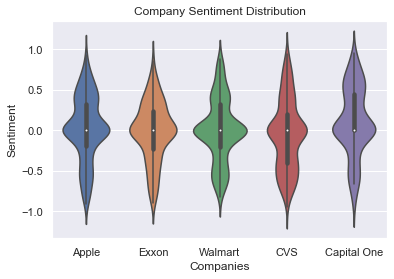

In [21]:
# Violin plot to show sentiment distribution
ax = sns.violinplot(x='Company', y='Sentiment', data=tweet_df)
ax.set_title('Company Sentiment Distribution')
ax.set_xlabel('Companies')
ax.set_ylabel('Sentiment')

These distributions tell us that the sentiment for most tweets is still neutral, but there is a better distribution of sentiment on these tweets compared to our last dataset which is a nice indicator, and there are far more negative ones than before, giving us a fulller spectrum of opinions. Let's see how the sentiment of these tweets fares against our close price data.

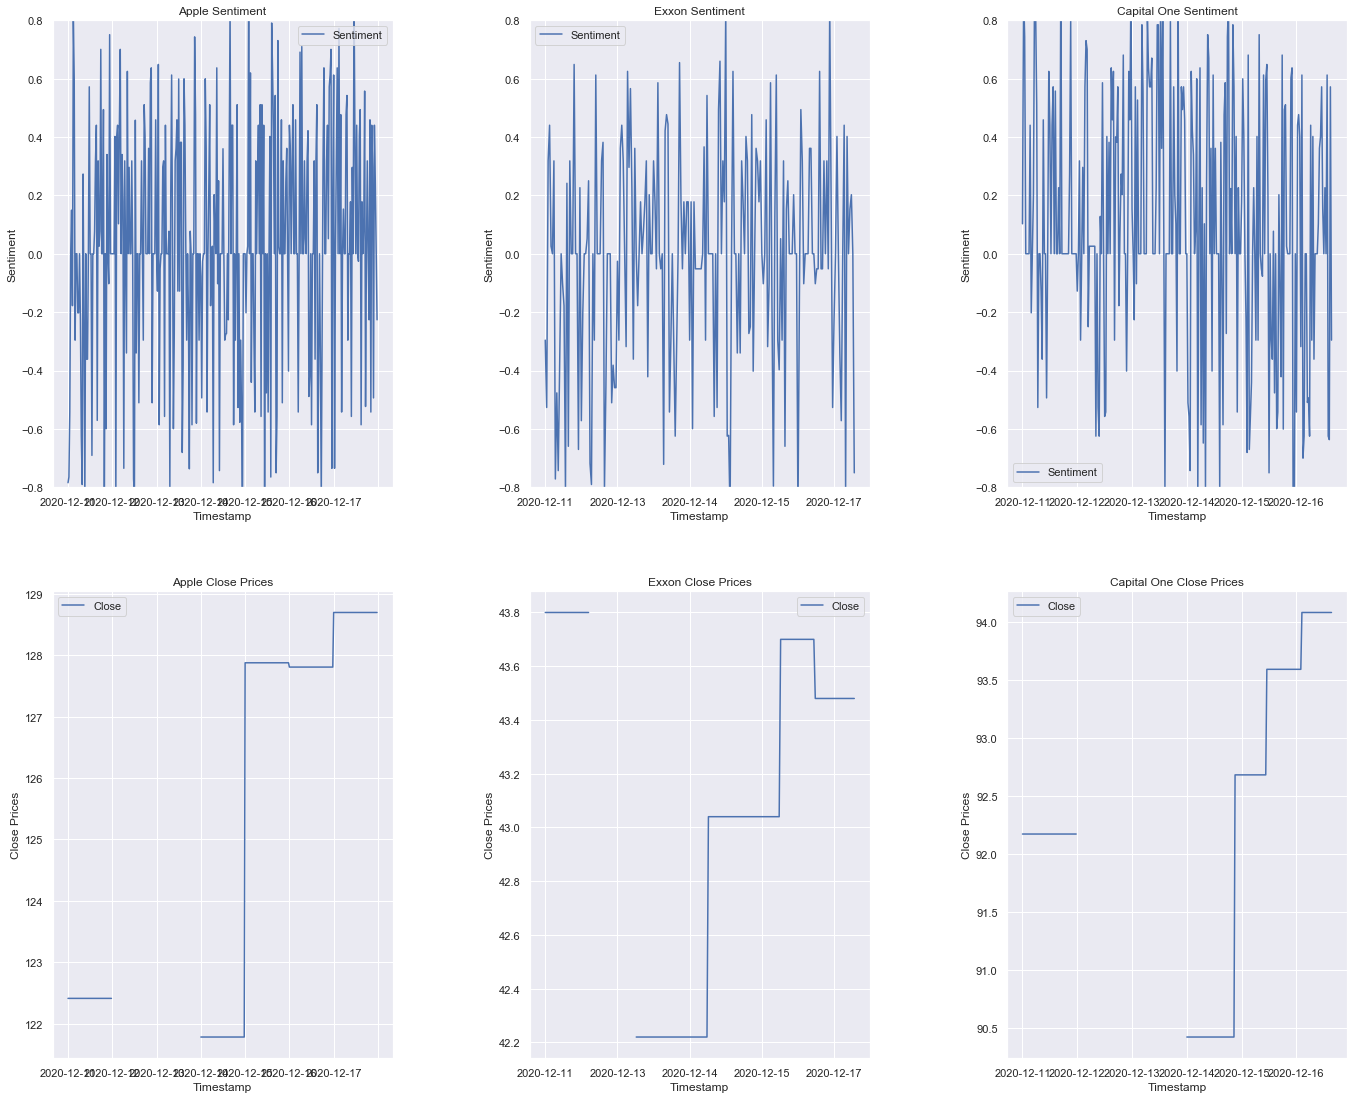

In [22]:
fig, axs = plt.subplots(2, 3)
syms = tweet_df.Symbol
fig.tight_layout(pad=0.25)

# Graph Sentiment vs Time for 3 companies
axs[0, 0].set_ylim([-0.8, 0.8]); axs[0, 1].set_ylim([-0.8, 0.8]); axs[0, 2].set_ylim([-0.8, 0.8])
sentiment_kwargs = {'x': 'Date', 'y': 'Sentiment', 'figsize': (20, 16), 'ylabel': 'Sentiment', 'xlabel': 'Timestamp'}

tweet_df[syms == 'AAPL'].plot.line(ax=axs[0, 0], title='Apple Sentiment', **sentiment_kwargs)
tweet_df[syms == 'XOM'].plot.line(ax=axs[0, 1], title='Exxon Sentiment', **sentiment_kwargs)
tweet_df[syms == 'COF'].plot.line(ax=axs[0, 2], title='Capital One Sentiment', **sentiment_kwargs)

# Graph stock performance vs Time for 3 companies
price_kwargs = {'x': 'Date', 'y': 'Close', 'xlabel': 'Timestamp', 'ylabel': 'Close Prices'}

tweet_df[syms == 'AAPL'].plot.line(ax=axs[1, 0], title='Apple Close Prices', **price_kwargs)
tweet_df[syms == 'XOM'].plot.line(ax=axs[1, 1], title='Exxon Close Prices', **price_kwargs)
tweet_df[syms == 'COF'].plot.line(ax=axs[1, 2], title='Capital One Close Prices', **price_kwargs)

These sentiment graphs are definitely more extreme than before which is an improvement on our previous Twitter dataset since we have actual sentiment we can track. Since the sentiment is all over the place, we will need to normalize it.

The stock price data also has gaps in it because we are looking at a week's worth of data and the market is not open on weekends.

The Twitter API definitely performed better than the Kaggle Twitter dataset since these tweets are much more emotional in nature which makes the Vader sentiment tagging more valuable. We are limited by the fact that we can only look at 7 days of tweets which means we can't assess long-term trends.

# Aggregating Twitter Sentiment
Twitter sentiment was too noisy from before. Let's try aggregating it for each day and looking at those trends.

In [23]:
# For each company on each day, get the average of the sentiment
rel_cols = ['Symbol', 'Date', 'Sentiment', 'Close']
net_df = tweet_df[rel_cols].groupby(['Symbol', 'Date']).mean().reset_index()
net_df.head()

,Symbol,Date,Sentiment,Close
0,AAPL,2020-12-11,-0.066792,122.410004
1,AAPL,2020-12-12,0.062244,NaN
2,AAPL,2020-12-13,0.010432,NaN
3,AAPL,2020-12-14,-0.039218,121.779999
4,AAPL,2020-12-15,0.041872,127.879997


Let's visualize the sentiment and close prices now

[Text(0, 0.5, 'Close Price'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Close Price per Day')]

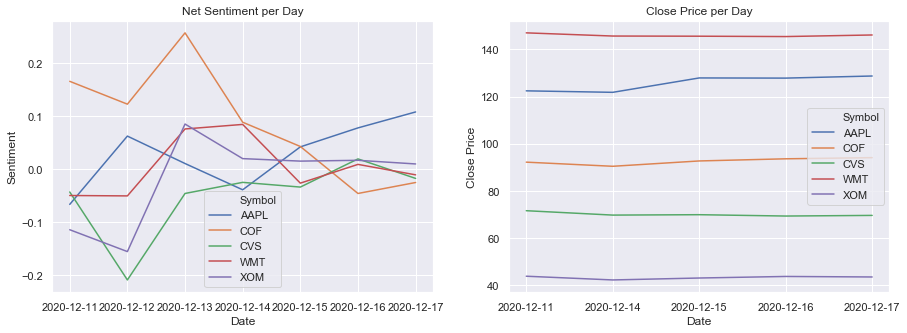

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(x='Date', y='Sentiment', hue='Symbol', data=net_df, ax=ax1)
ax1.set(title='Net Sentiment per Day', xlabel='Date', ylabel='Sentiment')

sns.lineplot(x='Date', y='Close', hue='Symbol', data=net_df, ax=ax2)
ax2.set(title='Close Price per Day', xlabel='Date', ylabel='Close Price')

The net sentiment is much easier to look at now that it is aggregated for each day. The close prices are not very interesting since it is only over a week. With more Twitter data, this would likely yield more interesting results. Regardless, this serves as an interesting proof of concept.

# Linear Regression using Twitter Sentiment
Even though we are low on Twitter data, we thought it would be interesting to create linear regression models to try and predict close prices for each company solely based on sentiment. This is more for proof of concept since 7 days of data likely is not enough to make accurate predictions.

Let's train the Linear Regression models!

In [28]:
# Add each model to the dictionary, reg, after training
reg = {}
net_df.dropna(inplace=True)

for company in net_df.Symbol.unique():
    comp = net_df.loc[net_df.Symbol == company, ['Sentiment', 'Close']]
    reg[company] = lm.LinearRegression()
    reg[company].fit(comp[['Sentiment']], comp['Close'])

Let's view the p-values of such linear models. We will have to use StatsModels since SKlearn does not show p-values.

In [32]:
for company in net_df.Symbol.unique():
    res = statsmodels.formula.api.ols(formula="Close ~ Sentiment", data=(net_df[net_df.Symbol == company])).fit()
    print(f'{company}:\n {dict(res.pvalues)}')

AAPL:
 {'Intercept': 2.0345793859772924e-07, 'Sentiment': 0.012763178293094113}
COF:
 {'Intercept': 6.276400725189746e-07, 'Sentiment': 0.1927494906228867}
CVS:
 {'Intercept': 5.818992766521759e-07, 'Sentiment': 0.1759823148586251}
WMT:
 {'Intercept': 1.4074312891275883e-08, 'Sentiment': 0.31781633871386916}
XOM:
 {'Intercept': 6.809544143610455e-07, 'Sentiment': 0.37698980564595486}


There was a lot of variability, but unfortunately none of our models had a p-value less than .05. So we can't call the results significant. There were issues with our data not covering a wide enough timeframe and the close prices being relatively static so it's too soon to rule out a correlation entirely. It's encouraging that the best performing model was for Apple which was the stock with the most movement in our timeframe. This may suggest that we could do better if repeated this on a bigger period with more room for change in the stock price.

# Reddit API
Twitter has been commonly used by large companies to report to the general public on news. We will now look at the Reddit API to see if we can generate more interesting correlations to provide insight into stock performance.